In [ ]:
# inthis we import pandas as pd and otherss importaart libraries for data analysis and manipulation also for modling and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

In [4]:
# Load the dataset

df = pd.read_csv("OnlineRetail.csv", encoding="ISO-8859-1")
print(df.head())


  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

      InvoiceDate  UnitPrice  CustomerID         Country  
0  12/1/2010 8:26       2.55     17850.0  United Kingdom  
1  12/1/2010 8:26       3.39     17850.0  United Kingdom  
2  12/1/2010 8:26       2.75     17850.0  United Kingdom  
3  12/1/2010 8:26       3.39     17850.0  United Kingdom  
4  12/1/2010 8:26       3.39     17850.0  United Kingdom  


In [5]:
# Check for columns and data types
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [6]:
# Calculate total price for each transaction
df["total_price"] = df["Quantity"] * df["UnitPrice"]

In [7]:
#  drop null  values in 'CustomerID' column
df = df.dropna(subset=['CustomerID'])


In [8]:
# Check for missing values
df.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
total_price    0
dtype: int64

In [9]:
# Drop unnecessary columns for clustering
x=df.drop(["StockCode","Description","Country"],axis=1)
x.head()

,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID,total_price
0,536365,6,12/1/2010 8:26,2.55,17850.0,15.30
1,536365,6,12/1/2010 8:26,3.39,17850.0,20.34
2,536365,8,12/1/2010 8:26,2.75,17850.0,22.00
3,536365,6,12/1/2010 8:26,3.39,17850.0,20.34
4,536365,6,12/1/2010 8:26,3.39,17850.0,20.34


In [10]:
# Convert 'InvoiceDate' to datetime
x["InvoiceDate"] = pd.to_datetime(x["InvoiceDate"])

In [11]:
# Check the shape of the dataset
x.shape

(406829, 6)

In [12]:
# head of the dataset
x.head()

,InvoiceNo,Quantity,InvoiceDate,UnitPrice,CustomerID,total_price
0,536365,6,2010-12-01 08:26:00,2.55,17850.0,15.30
1,536365,6,2010-12-01 08:26:00,3.39,17850.0,20.34
2,536365,8,2010-12-01 08:26:00,2.75,17850.0,22.00
3,536365,6,2010-12-01 08:26:00,3.39,17850.0,20.34
4,536365,6,2010-12-01 08:26:00,3.39,17850.0,20.34


In [13]:
# Calculate the reference date for recency calculation
reference_date = x['InvoiceDate'].max() + pd.Timedelta(days=1)


In [14]:
# Create RFM features
rfm = x.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',   # Frequency (unique orders)
    'total_price': 'sum'      # Monetary (total spend)
}).reset_index()


In [15]:
# Rename columns for clarity
rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
print(rfm.head())

   CustomerID  Recency  Frequency  Monetary
0     12346.0      326          2      0.00
1     12347.0        2          7   4310.00
2     12348.0       75          4   1797.24
3     12349.0       19          1   1757.55
4     12350.0      310          1    334.40


In [32]:
import numpy as np

q1 = np.percentile(rfm['Monetary'], 25)
q3 = np.percentile(rfm['Monetary'], 75)
iqr = q3 - q1

lower = q1 - 1.5 * iqr
upper = q3 + 1.5 * iqr

rfm = rfm[(rfm['Monetary'] >= lower) & (rfm['Monetary'] <= upper)]


In [33]:
# check the top customers based on monetary value in ascending order
rfm["Monetary"].sort_values(ascending=False).head()

1327    3580.13
56      3578.80
3579    3563.85
2320    3563.11
815     3550.70
Name: Monetary, dtype: float64

C:\Users\Dell 5490T\AppData\Local\Temp\ipykernel_15224\381536973.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


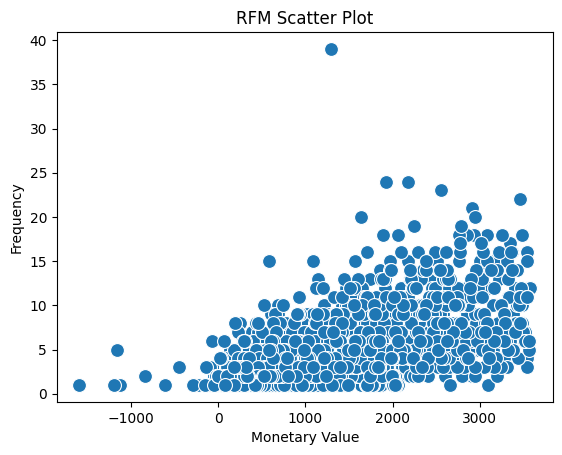

In [34]:
 # Visualize the RFM features for checking the distribution of customers based on their recency, frequency, and monetary values outliers and patterns in the data
sns.scatterplot(
    x=rfm['Monetary'],
    y=rfm['Frequency'],
    palette='Set2',
    s=100
)
plt.title("RFM Scatter Plot")
plt.xlabel("Monetary Value")
plt.ylabel("Frequency")
plt.show()

In [35]:
# Create RFM scores by binning the features into 5 quantiles and assigning scores from 1 to 5 (5 being the best score for each feature)
rfm['R_score'] = pd.qcut(rfm['Recency'], 5, labels=[5, 4, 3, 2, 1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method="first"), 5, labels=[1,2,3,4,5])

rfm['M_score'] = pd.qcut(rfm['Monetary'], 5, labels=[1, 2, 3, 4, 5])

In [36]:
# Combine R, F, and M scores to create an overall RFM score
rfm["Rfm_Score"] = rfm['R_score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_score'].astype(str)

In [37]:
# check the head of the RFM dataframe with scores
rfm1=rfm.drop(["Recency","Frequency","Monetary"],axis=1)

In [38]:
# check the head of the RFM dataframe with scores
rfm1.head()


,CustomerID,R_score,F_Score,M_score,Rfm_Score,cluster,cluster_status
0,12346.0,1,2,1,121,1,New Customers
2,12348.0,3,4,5,345,3,Loyal Customers
3,12349.0,4,1,5,415,3,Loyal Customers
4,12350.0,1,1,2,112,1,New Customers
5,12352.0,4,5,5,455,3,Loyal Customers


In [39]:
# standardize the RFM features before applying K-means clustering to ensure that all features contribute equally to the distance calculations in the clustering algorithm
scaler=StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency','Frequency','Monetary']])

In [40]:
# Determine the optimal number of clusters using the Elbow method
wcss=[]
for i in range(1,11):
    kmean=KMeans(n_clusters=i,init="k-means++",random_state=42)
    kmean.fit(rfm_scaled)
    wcss.append(kmean.inertia_)   

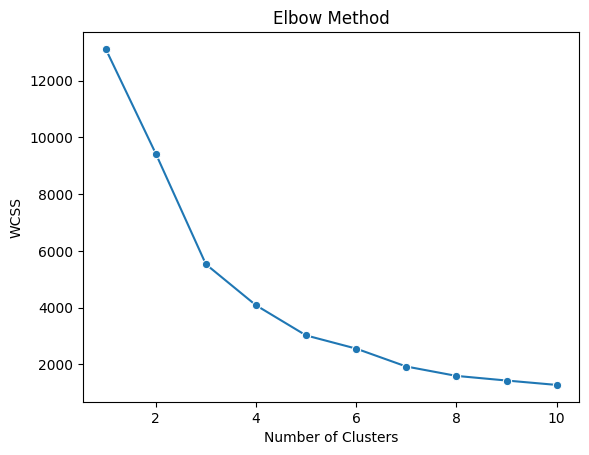

In [24]:
sns.lineplot(x=range(1,11),y=wcss,marker="o")
plt.title("Elbow Method")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.show()

In [43]:
# making clusters by using kmeans 
kmen=KMeans(n_clusters=4,random_state=42)
rfm["cluster"]=kmen.fit_predict(rfm_scaled)


In [44]:
# just find the score in this show that how cluster perform
score=silhouette_score(rfm_scaled, rfm["cluster"])
print("Silhouette Score:", score)

Silhouette Score: 0.42869302441564194


In [45]:
# in this we make clusters centers 
centers = kmen.cluster_centers_


In [46]:
# transform the centers into original
centers_original = scaler.inverse_transform(centers)



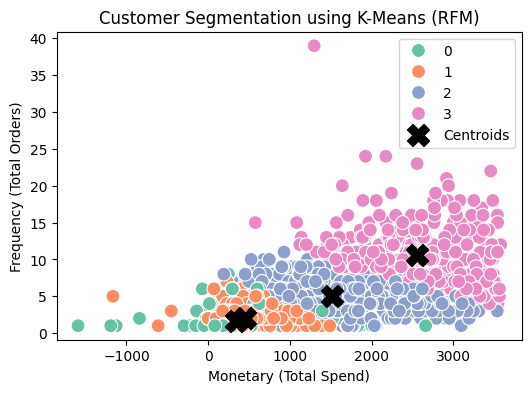

In [47]:

# we make a graph scaterplot to show the clusters
plt.figure(figsize=(6,4))
sns.scatterplot(
    x=rfm['Monetary'],
    y=rfm['Frequency'],
    hue=rfm['cluster'],
    palette='Set2',
    s=100
)

# Centroids plot (original scale)
plt.scatter(
    centers_original[:,2],   # Monetary centroid
    centers_original[:,1],   # Frequency centroid
    c="black",
    s=250,
    marker="X",
    label="Centroids"
)

plt.title("Customer Segmentation using K-Means (RFM)")
plt.xlabel("Monetary (Total Spend)")
plt.ylabel("Frequency (Total Orders)")
plt.legend() 
plt.show()


In [48]:
#in this we check clusters  perfom well or not
rfm["cluster_status"] = rfm["cluster"].map({
    0: "Low Value Customers",
    1: "New Customers",
    2: "loyal Customers",
    3: "vip Customers"
})

rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_score,F_Score,M_score,Rfm_Score,cluster,cluster_status
0,12346.0,326,2,0.00,1,2,1,121,0,Low Value Customers
2,12348.0,75,4,1797.24,3,4,5,345,2,loyal Customers
3,12349.0,19,1,1757.55,4,1,5,415,2,loyal Customers
4,12350.0,310,1,334.40,1,1,2,112,0,Low Value Customers
5,12352.0,36,11,1545.41,4,5,5,455,3,vip Customers
